In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
from Bio import SeqIO
from Bio import Align
import numpy as np
from functools import reduce
from utils import load_patients, load_viruses

In [26]:
viruses_full = load_viruses()
patients_identity_full, patients_entries_full = load_patients()

viral.3.2.genomic.fna	... Done.
viral.2.3.genomic.fna	... Done.
viral.3.1.genomic.fna	... Done.
viral.2.1.genomic.fna	... Done.
viral.1.1.genomic.fna	... Done.
viral.2.4.genomic.fna	... Done.
viral.2.2.genomic.fna	... Done.
PT8-S2.fastq	... Done.
PT9-S1.fastq	... Done.
PT8-S1.fastq	... Done.
PT7-S1.fastq	... Done.
PT2-S1_1.fastq	... Done.


In [33]:
print(patients_entries_full.shape)
print(patients_identity_full.shape)
np.random.shuffle(np.arange(patients_entries_full.shape[0]))

(310541,)
(310541,)


In [28]:
import json
with open('popular_virus_names.json', 'r') as f:
    popular_viruses_keys = json.load(f)

In [68]:
np.random.seed(42)
viruses = {k:viruses_full[k] for k in popular_viruses_keys[:5]}
random_idx = np.arange(patients_entries_full.shape[0])
np.random.shuffle(random_idx)
random_idx = random_idx[:10]
patients_entries = patients_entries_full[random_idx]
patients_identity = patients_identity_full[random_idx]

In [69]:
len(viruses), patients_entries.shape

(5, (10,))

In [81]:
from multiprocessing import Pool

aligner = Align.PairwiseAligner()

def compute_virus_alignement_score(params):
    global aligner
    patients_entries, virus_dna = params
    alignments_scores = np.zeros((patients_entries.shape[0]))
    if len(virus_dna) == 0:
        return alignments_scores
    
    for i, patient_dna in enumerate(patients_entries):
        print(len(patient_dna), len(virus_dna))
        if len(patient_dna) != 0:
            alignments_scores[i] = aligner.align(patient_dna, virus_dna).score
            for a in aligner.align(patient_dna, virus_dna):
                print()
        else:
            alignments_scores[i] = 0
    print(alignments_scores)
    
    return alignments_scores

# with Pool(7) as p:
#     alignements_scors_list = p.map(
#         compute_virus_alignement_score, 
#         [(patients_entries, v_dna) for v_dna in viruses.values()]
#     )

alignements_scors_list = list(map(
        compute_virus_alignement_score, 
        [(patients_entries, v_dna) for v_dna in viruses.values()]
    ))

result = np.array(alignements_scors_list).T

150 152222


OverflowError: number of optimal alignments is larger than 9223372036854775807

In [71]:
result

array([[150., 150., 150., 150., 150.],
       [150., 150., 150., 150., 150.],
       [151., 151., 151., 151., 151.],
       [151., 151., 151., 151., 151.],
       [301., 301., 301., 301., 301.],
       [121., 121., 121., 121., 121.],
       [150., 150., 150., 150., 150.],
       [  0.,   0.,   0.,   0.,   0.],
       [151., 151., 151., 151., 151.],
       [301., 301., 301., 301., 301.]])

In [62]:
result_copy = result.copy()

In [63]:
result_copy /= result_copy.max(axis=1)[:, None]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [64]:
result.std(axis=1)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [65]:
from matplotlib import pyplot as plt

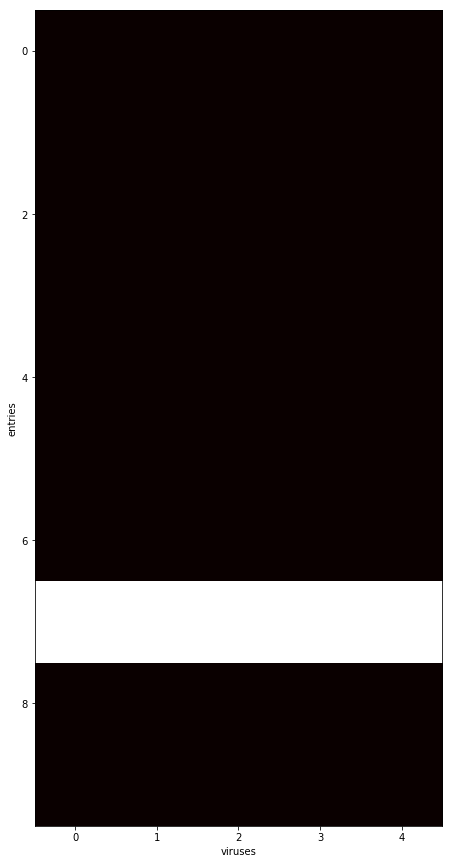

In [66]:
plt.figure(figsize=(15, 15))
plt.xlabel('viruses')
plt.ylabel('entries')
plt.imshow(result_copy, cmap='hot', interpolation='nearest')

In [55]:
print(list(result))

[array([150., 150., 150., 150., 150., 150., 150., 150., 150., 150., 150.,
       150., 150., 150., 150., 150., 150., 150., 150., 150., 150., 150.,
       150., 150., 150., 150., 150., 150., 150., 150., 150., 150., 150.,
       150., 150., 150., 150., 150., 150., 150., 150., 150., 150., 150.,
       150., 150., 150., 150., 150., 150., 150., 150., 150., 150., 150.,
       150., 150., 150., 150., 150., 150., 150., 150., 150., 150., 150.,
       150., 150., 150., 150., 150., 150., 150., 150., 150., 150., 150.,
       150., 150., 150., 150., 150., 150., 150., 150., 150., 150.]), array([150., 150., 150., 150., 150., 150., 150., 150., 150., 150., 150.,
       150., 150., 150., 150., 150., 150., 150., 150., 150., 150., 150.,
       150., 150., 150., 150., 150., 150., 150., 150., 150., 150., 150.,
       150., 150., 150., 150., 150., 150., 150., 150., 150., 150., 150.,
       150., 150., 150., 150., 150., 150., 150., 150., 150., 150., 150.,
       150., 150., 150., 150., 150., 150., 150., 150.,

In [48]:
result.shape

(100, 87)

In [42]:
patients_identity

array(['PT9-S1', 'PT9-S1', 'PT9-S1', 'PT9-S1', 'PT2-S1_1', 'PT7-S1',
       'PT8-S2', 'PT7-S1', 'PT9-S1', 'PT2-S1_1', 'PT7-S1', 'PT8-S2',
       'PT7-S1', 'PT9-S1', 'PT7-S1', 'PT7-S1', 'PT9-S1', 'PT7-S1',
       'PT7-S1', 'PT7-S1', 'PT8-S1', 'PT7-S1', 'PT7-S1', 'PT9-S1',
       'PT9-S1', 'PT8-S1', 'PT7-S1', 'PT7-S1', 'PT7-S1', 'PT9-S1',
       'PT7-S1', 'PT8-S1', 'PT7-S1', 'PT7-S1', 'PT7-S1', 'PT2-S1_1',
       'PT7-S1', 'PT7-S1', 'PT8-S2', 'PT9-S1', 'PT8-S2', 'PT2-S1_1',
       'PT2-S1_1', 'PT7-S1', 'PT7-S1', 'PT7-S1', 'PT7-S1', 'PT7-S1',
       'PT7-S1', 'PT7-S1', 'PT9-S1', 'PT8-S2', 'PT9-S1', 'PT9-S1',
       'PT7-S1', 'PT7-S1', 'PT7-S1', 'PT7-S1', 'PT7-S1', 'PT8-S1',
       'PT9-S1', 'PT7-S1', 'PT9-S1', 'PT7-S1', 'PT7-S1', 'PT7-S1',
       'PT7-S1', 'PT8-S1', 'PT9-S1', 'PT7-S1', 'PT7-S1', 'PT7-S1',
       'PT8-S1', 'PT9-S1', 'PT9-S1', 'PT7-S1', 'PT9-S1', 'PT7-S1',
       'PT7-S1', 'PT8-S1', 'PT7-S1', 'PT7-S1', 'PT7-S1', 'PT9-S1',
       'PT7-S1', 'PT9-S1', 'PT7-S1', 'PT9-S1', 'PT7-